In [37]:
pip install adjustText

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from itertools import product
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools
from adjustText import adjust_text

In [3]:
#Upload csv
df = pd.read_csv('abundance_ProteinGroups.csv')

In [4]:
#Exclude the <= 20% sequence coverage: 1740, create new dataset
df_exclude = df[df['Sequence coverage [%]'] > 20]
count_max20_coverage = df_exclude.shape[0]
print('Number of proteins with > 20% sequence coverage:', count_max20_coverage)

Number of proteins with > 20% sequence coverage: 2089


In [5]:
#subset for exclude dataframe contaiing only important labels
key_keep_cols = ['Protein IDs', 'Protein names', 'Gene names']  
intensity_cols = [col for col in df.columns if col.startswith('Intensity')]  

df_excludesub = df_exclude[key_keep_cols + intensity_cols]

#print the shape and first few rows as a check  
print("Exclude dataset shape:", df_excludesub.shape)  
#print("Preprocessed data preview:")  
#print(df_preprocessed.head())  
   
# Optionally, save the preprocessed dataframe for further analysis  
df_excludesub.to_csv('exclusesubset_proteomics.csv', index=False)  
print("excludesubset data saved as 'exclusesubset_proteomics.csv'") 

Exclude dataset shape: (2089, 51)
excludesubset data saved as 'exclusesubset_proteomics.csv'


Transform

In [6]:
#Copy and replace 0 per nan in intensity columns
df_log_exc = df_excludesub.copy()
df_log_exc[intensity_cols] = df_log_exc[intensity_cols].replace(0, np.nan)
df_log_exc[intensity_cols] = np.log2(df_log_exc[intensity_cols])

In [7]:
#Add Iterative Imputer to df_log_exc
df_log_exc_II = df_log_exc.copy()
intensity_cols = [col for col in df_log_exc_II.columns if col.startswith('Intensity')]
imputer = IterativeImputer(random_state=42)

#Fit and transform
df_log_exc_II[intensity_cols] = imputer.fit_transform(df_log_exc_II[intensity_cols])

#Check if there are any missing values left
print("Remaining missing values:", df_log_exc_II[intensity_cols].isnull().sum().sum())

Remaining missing values: 0


C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [8]:
#add StandardScaler() to df_exc_II
# Create a copy of just the intensity data for normalization
intensity_data = df_log_exc_II[intensity_cols].copy()
std_scaler = StandardScaler()
df_log_exc_II_std = pd.DataFrame(std_scaler.fit_transform(intensity_data), columns=intensity_cols)

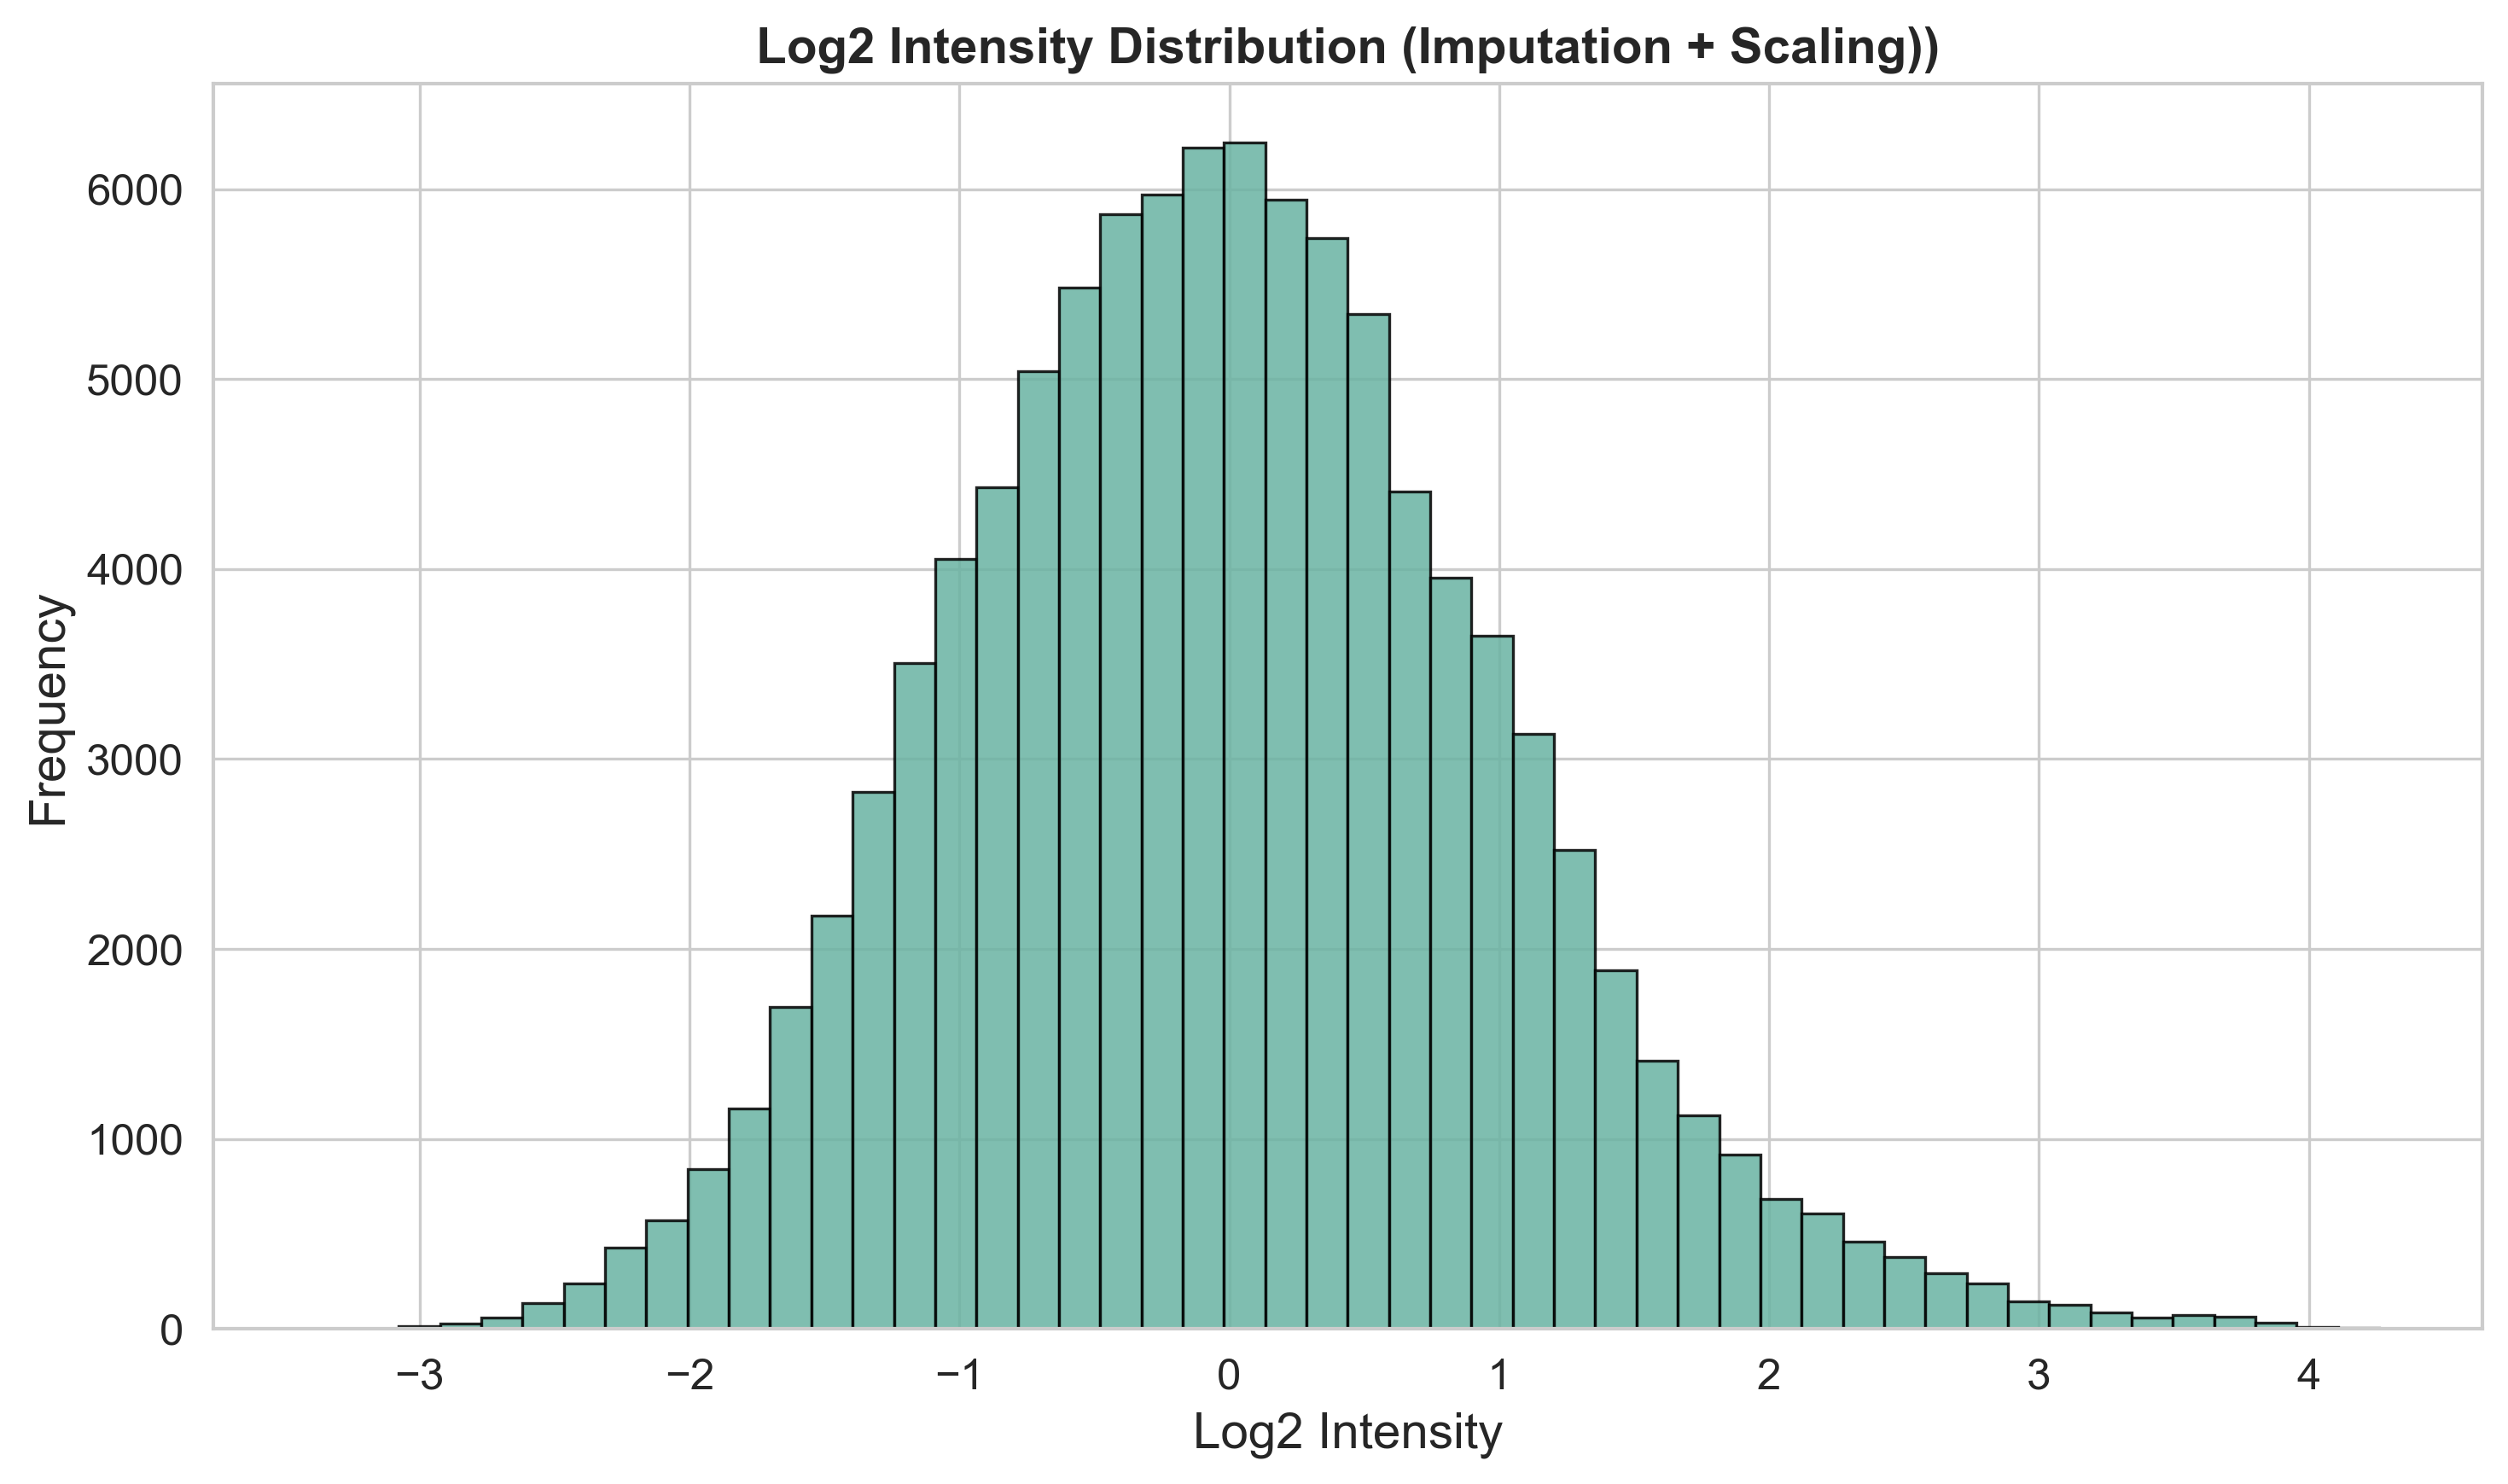

In [10]:
#Visualization of distribution after scaling
sns.set(style="whitegrid", context="paper", font_scale=1.4)
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(df_log_exc_II_std[intensity_cols].stack(), bins=50, color='#69b3a2', edgecolor='black', alpha=0.85)
plt.title('Log2 Intensity Distribution (Imputation + Scaling))', fontsize=14, weight='bold')
plt.xlabel('Log2 Intensity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#Save labaled curated dataset

In [11]:
df_labels = pd.read_csv('exclusesubset_proteomics.csv')

In [12]:
df_log_labeled = pd.concat(
    [df_labels[['Protein IDs', 'Protein names', 'Gene names']], df_log_exc_II_std],
    axis=1
)

In [13]:
df_log_labeled.to_csv('df_curated_proteomics.csv', index=False)  
print("df_curated_proteomics data saved as 'df_curated_proteomics.csv'") 

df_curated_proteomics data saved as 'df_curated_proteomics.csv'


Reduce diemnsionality

In [14]:
df_log_exc_II_std.to_csv('processed_proteomic.csv', index=False)

In [375]:
print(df_log_exc_II_std.shape)

(2089, 48)


In [15]:
#Transposed data log2, II, Scaled
df_transposed = df_log_exc_II_std.T

In [16]:
#Transposed df_excludesub for metadata
df_metadata = df_excludesub.T

In [17]:
#Apply UMAP_Tune
!pip install umap-learn
import umap

Defaulting to user installation because normal site-packages is not writeable


In [18]:
#Apply PCA before
X = df_transposed.values

pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X)

In [20]:
#Fit UMAP_tune, unse X_pca
umap_tune = umap.UMAP(n_neighbors=3, min_dist=0.001, metric='cosine', n_components=2, random_state=42)
umap_tune.fit(X_pca)
df_transposed_umap_tune = umap_tune.transform(X_pca)

C:\Users\laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


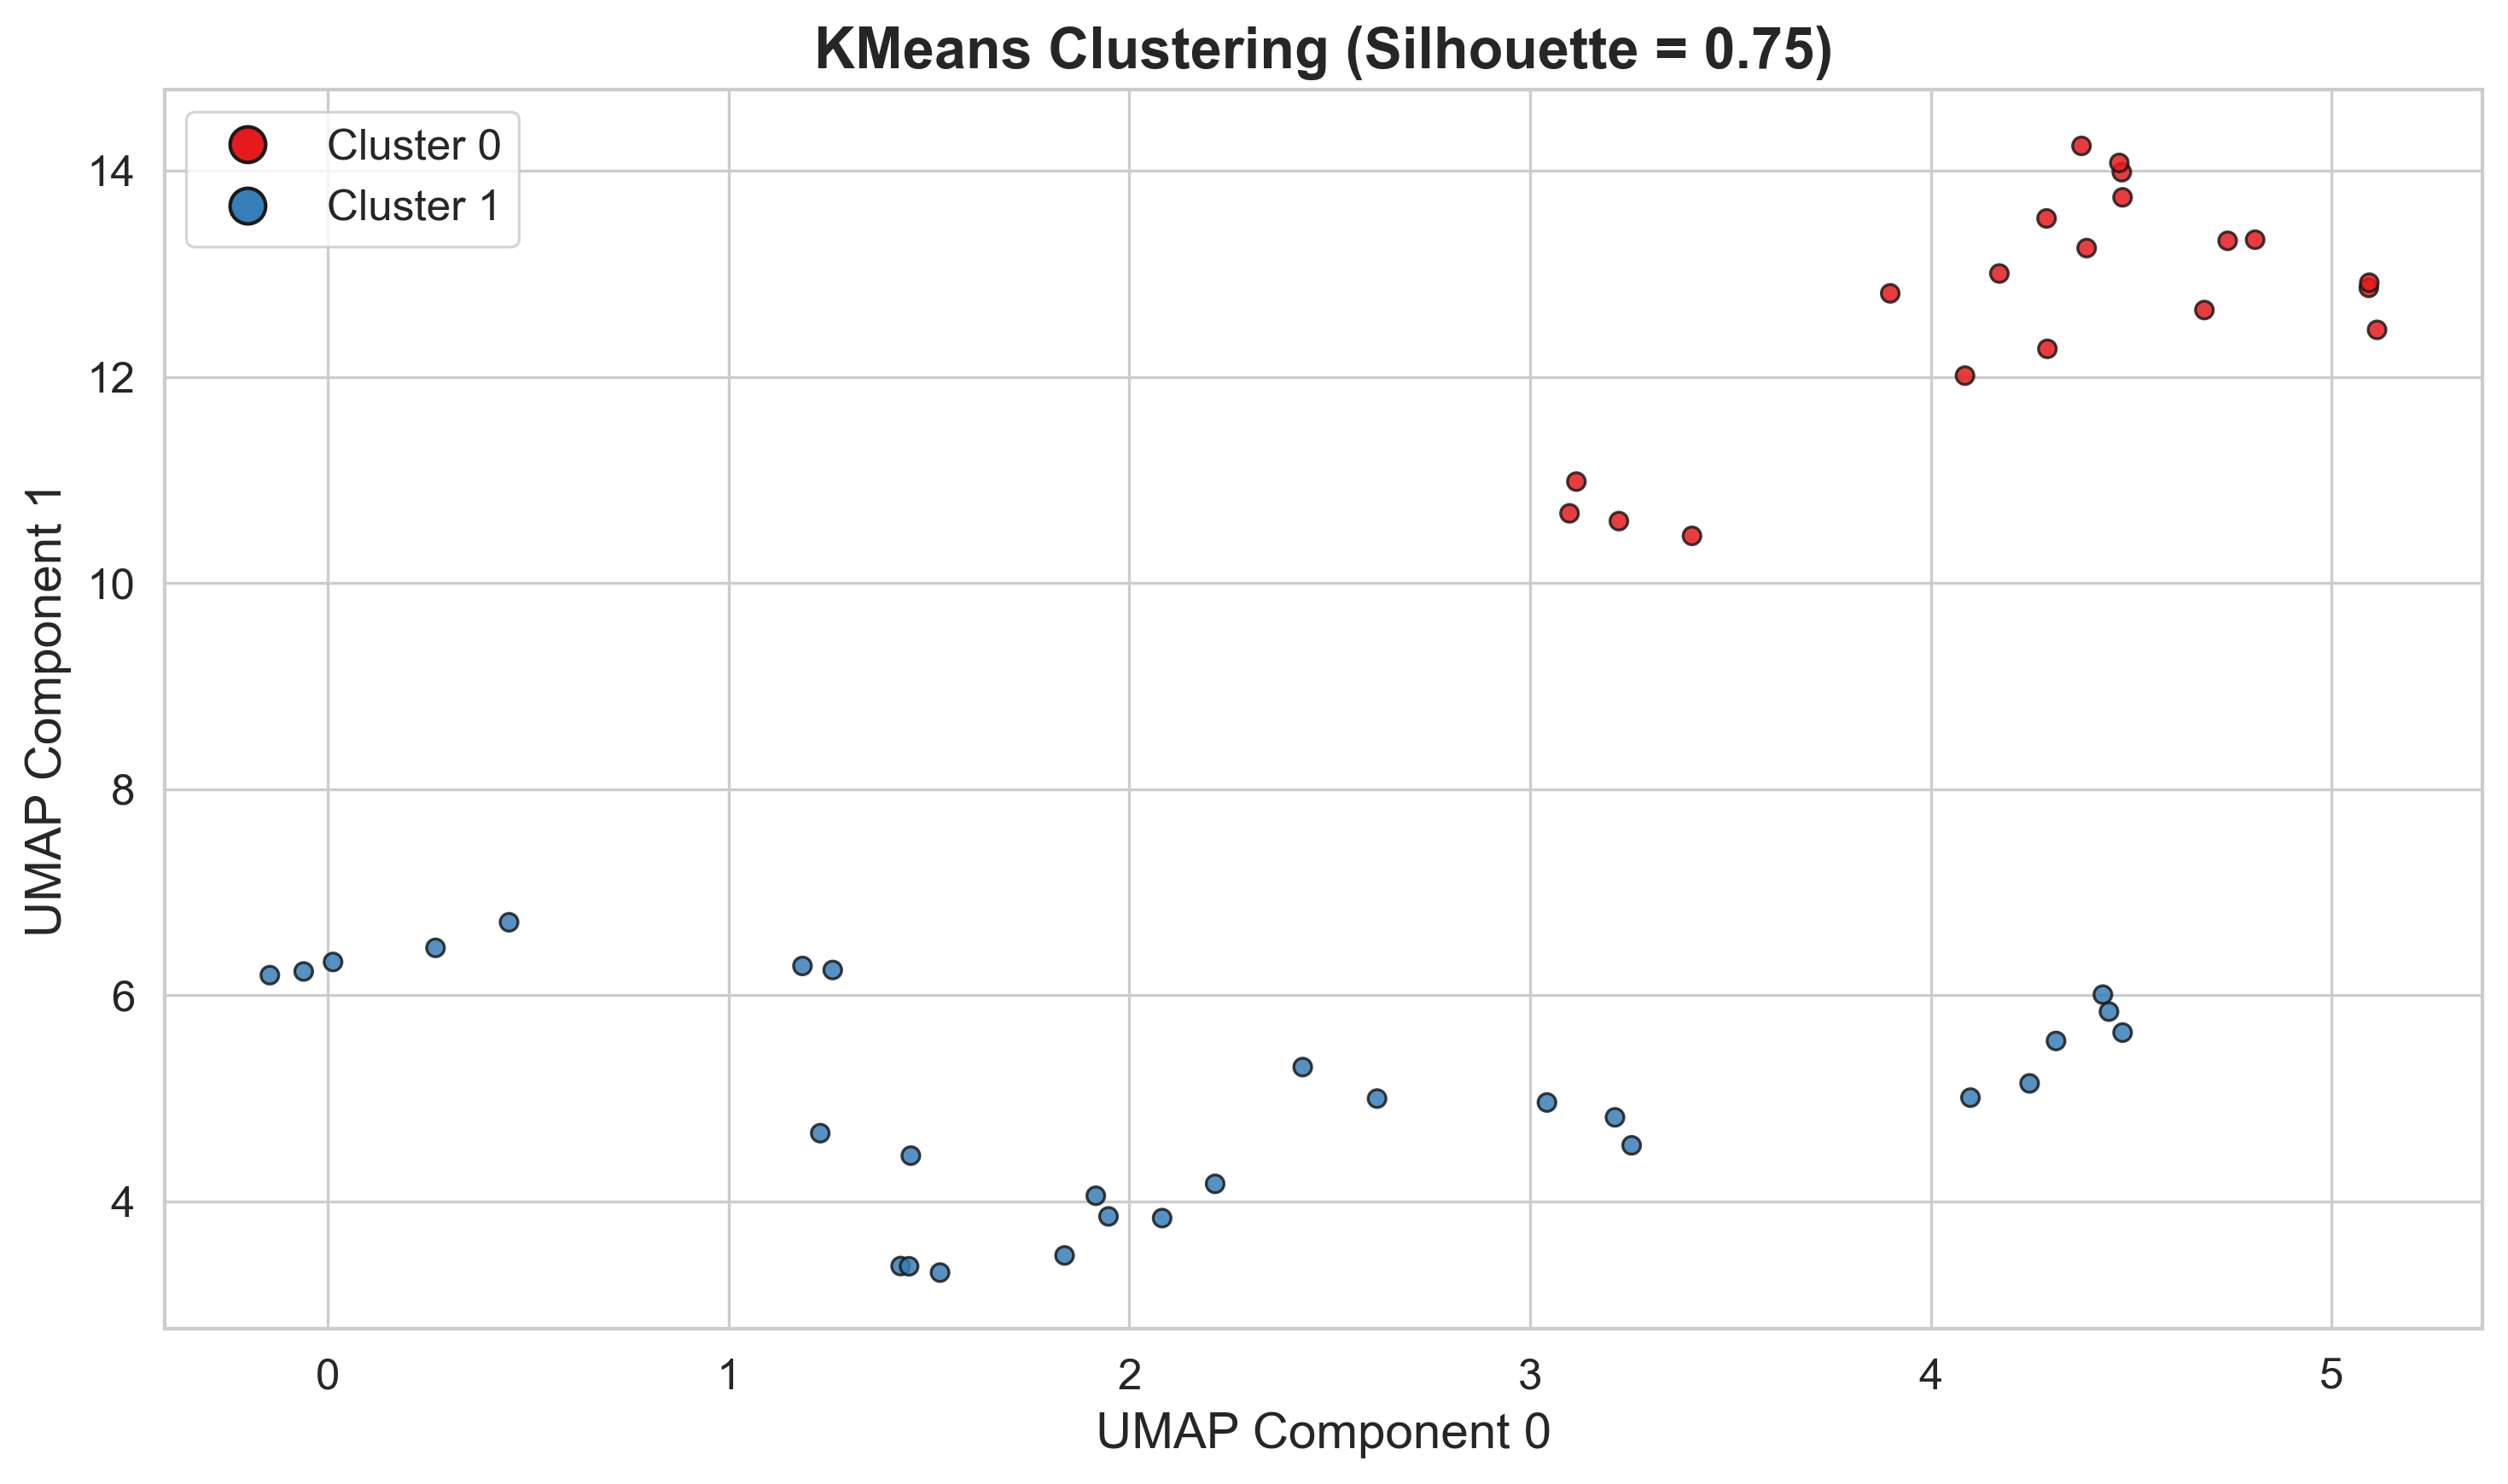

In [21]:
#Cluster visualizatio with Kmeans
# Fit KMeans
clustering_kmeans = KMeans(
    n_clusters=2, random_state=74, max_iter=500,
    init='k-means++', n_init='auto'
).fit(df_transposed_umap_tune)

# Get cluster labels and silhouette score
cluster_labels = clustering_kmeans.labels_
score = silhouette_score(df_transposed_umap_tune, cluster_labels)

# Plot
sns.set(style="whitegrid", context="paper", font_scale=1.4)
plt.figure(figsize=(10, 6), dpi=300)
palette = sns.color_palette("Set1", n_colors=2)
plt.scatter(
    df_transposed_umap_tune[:, 0], df_transposed_umap_tune[:, 1],
    s=25, c=[palette[label] for label in cluster_labels], edgecolor='k', alpha=0.85
)

plt.xlabel("UMAP Component 0", fontsize=14)
plt.ylabel("UMAP Component 1", fontsize=14)
plt.title(f"KMeans Clustering (Silhouette = {score:.2f})", fontsize=16, weight='bold')

#Legends
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+0}',
            markerfacecolor=palette[i], markersize=10, markeredgecolor='k') for i in range(2)]
plt.legend(handles=handles, loc='best')

plt.tight_layout()
plt.show()

In [22]:
cluster_labels_umap = cluster_labels

In [23]:
#Turn UMAP array into a DataFrame
df_umap_clustered = pd.DataFrame(df_transposed_umap_tune, columns=['UMAP Component 1', 'UMAP Component 2'])
df_umap_clustered['cluster'] = cluster_labels_umap

In [24]:
#Merging df_transposed and df_transposed_umap_tunee with aligned indices
df_clustered_full = df_transposed.copy()
df_clustered_full['cluster'] = cluster_labels_umap

In [40]:
df_clustered_full.head()

,0,1,2,3,4,5,6,7,8,9,...,2080,2081,2082,2083,2084,2085,2086,2087,2088,cluster
Intensity 1,3.557506,3.679202,2.958916,3.830367,3.442190,3.646276,2.904340,3.524816,2.856074,3.282263,...,-1.370406,-2.457030,-0.269005,-0.173895,-1.549028,-1.837964,-0.495724,4.600014e-14,4.715014e-14,1
Intensity 2,3.842408,3.798395,3.152779,3.371418,3.619659,3.184225,2.821229,2.990193,2.749026,2.708517,...,-1.765138,-2.361782,-0.433164,-0.637559,-1.104589,-1.326147,-0.246660,5.067674e-14,5.067674e-14,0
Intensity 3,3.616321,3.642589,3.094560,2.951131,3.415071,2.732727,3.160079,2.638905,3.102713,2.333988,...,-1.262111,-2.099332,-0.428360,-1.761870,-1.258362,-0.898859,0.002279,2.752966e-14,2.752966e-14,1
Intensity 4,3.601728,3.594440,3.067672,4.047587,3.492810,4.112331,2.704596,3.793546,2.539173,3.514980,...,-1.664580,-2.302554,-0.135339,0.110480,-1.479425,-1.412030,-0.552787,5.535377e-14,5.535377e-14,1
Intensity 5,4.085157,3.742628,2.679775,3.707076,2.930879,3.565455,3.505470,3.267621,3.178525,3.270209,...,-1.168854,-2.295919,-0.265443,-0.435391,-1.303418,-1.296844,-0.527469,7.834565e-15,8.953789e-15,1


In [25]:
df_clustered_inv = df_clustered_full .T

In [70]:
df_metadata.head()

,0,1,2,3,4,5,6,7,8,9,...,3760,3764,3771,3772,3776,3785,3810,3816,3821,3825
Protein IDs,P68871;F8W6P5;A0A0J9YWK4,P69905,P49327;A0A0U1RQF0;A0A0U1RRG3;A0A1B0GTR5;J3KTF0,P62805,P60709;G5E9R0;E7EVS6;C9JZR7;Q6S8J3;C9JUM1;C9JT...,Q16778;P06899;P33778;Q6DRA6;Q6DN03,P02675;D6REL8,K7EK07;P84243;K7EMV3;B4DEB1;K7ES00;Q6NXT2;K7EP01,P02679-2;P02679;C9JEU5;C9JC84,Q93077;Q7L7L0;P04908,...,Q14112-2;H0YJV3,P55259;P55259-4;P55259-2;I3L2Z7;I3L3I2,M0R0Q9,P13746;P13746-2,F8WB86;Q6PJ80;C9JLR4;Q92575,P01763,D6RHJ6,K7EJ46-3;K7EJ46-2;K7EJ46,E7EUI8;E7EM57,P06396-3;A0A0U1RQL8
Protein names,Hemoglobin subunit beta;LVV-hemorphin-7;Spinor...,Hemoglobin subunit alpha,Fatty acid synthase;[Acyl-carrier-protein] S-a...,Histone H4,"Actin, cytoplasmic 1;Actin, cytoplasmic 1, N-t...",Histone H2B type 2-E;Histone H2B type 1-J;Hist...,Fibrinogen beta chain;Fibrinopeptide B;Fibrino...,Histone H3;Histone H3.3;Histone H3.3C,Fibrinogen gamma chain,Histone H2A type 1-C;Histone H2A type 3;Histon...,...,Nidogen-2,Pancreatic secretory granule membrane major gl...,NaN,"HLA class I histocompatibility antigen, A-11 a...",UBX domain-containing protein 4,Ig heavy chain V-III region WEA,NaN,Small integral membrane protein 22,Glucose-6-phosphate 1-dehydrogenase,Gelsolin
Gene names,HBB,HBA1,FASN,HIST1H4A,ACTB,HIST2H2BE;HIST1H2BJ;HIST1H2BB,FGB,H3F3B;H3F3A;H3F3C,FGG,HIST1H2AC;HIST3H2A;HIST1H2AB,...,NID2,GP2,C3,HLA-A,UBXN4,NaN,JCHAIN,SMIM22,G6PD,GSN
Intensity 1,20205000000,26220000000,5607700000,36242000000,15784000000,24435000000,4989200000,18839000000,4499300000,11207000000,...,0,0,0,0,0,0,0,0,0,0
Intensity 2,89500000000,81811000000,21906000000,34226000000,56805000000,23358000000,11135000000,15720000000,9609300000,8846800000,...,0,0,0,0,0,0,0,0,0,0


Merge labels of metadata and cluster with matrix into df_grouped

In [34]:
#extract metadata from initial df_excludesub
#metadata = df_metadata[['Protein IDs']].copy()

In [35]:
#Combine metadata with df_clustered_full
#df_grouped = pd.concat([metadata.reset_index(drop=True), df_clustered_inv.reset_index(drop=True)], axis=1)

In [36]:
#df_grouped.tail()

In [46]:
df_grouped.to_csv('df_grouped_proteomics.csv', index=False)  
print("edf_grouped data saved as 'df_grouped_proteomics.csv'") 

edf_grouped data saved as 'df_grouped_proteomics.csv'


Differential Expression Analysis DEA without metadata

In [38]:
df_clustered_full.to_csv('df_clustered_full.csv', index=False)  
print("df_clustered_full data saved as 'df_clustered_full.csv'") 

df_clustered_full data saved as 'df_clustered_full.csv'


DIFFERENTIAL EXPRESSION ANALYSIS

In [3]:
#Load df with cluster column
df_DEA = pd.read_csv("df_clustered_full.csv")
cluster_col = 'cluster'

In [4]:
# Separate expression matrix and clusters
expr = df_DEA.drop(columns=[cluster_col])
clusters = df_DEA[cluster_col]

In [7]:
results = []
cluster_ids = sorted(clusters.dropna().unique())

for cluster_a, cluster_b in itertools.combinations(cluster_ids, 2):
    group_a = expr[clusters == cluster_a]
    group_b = expr[clusters == cluster_b]

    for protein in expr.columns:
        values_a = group_a[protein].replace(0, pd.NA).dropna()
        values_b = group_b[protein].replace(0, pd.NA).dropna()

        if len(values_a) < 2 or len(values_b) < 2:
            continue

        stat, pval = ttest_ind(values_a, values_b, equal_var=False)
        mean_diff = values_a.mean() - values_b.mean()

        results.append({
            'Protein': protein,
            'Cluster 1': cluster_a,
            'Cluster 2': cluster_b,
            'Mean Diff': mean_diff,
            'p-value': pval
        })

In [8]:
results_df = pd.DataFrame(results)
results_df['FDR'] = multipletests(results_df['p-value'], method='fdr_bh')[1]

In [9]:
results_df.to_csv("DEA_transposed_clusters.csv", index=False)

In [10]:
df_plot = pd.read_csv("DEA_transposed_clusters.csv")

In [11]:
df_plot['log2_FC'] = df_plot['Mean Diff']
df_plot['neg_log10_FDR'] = -np.log10(df_plot['FDR'])

In [12]:
fc_thresh = 0.25
fdr_thresh = 0.05

In [13]:
df_plot['significant'] = 'Not significant'
df_plot.loc[(abs(df_plot['log2_FC']) >= fc_thresh) & (df_plot['FDR'] < fdr_thresh), 'significant'] = 'Significant'

<Axes: xlabel='log2_FC', ylabel='neg_log10_FDR'>

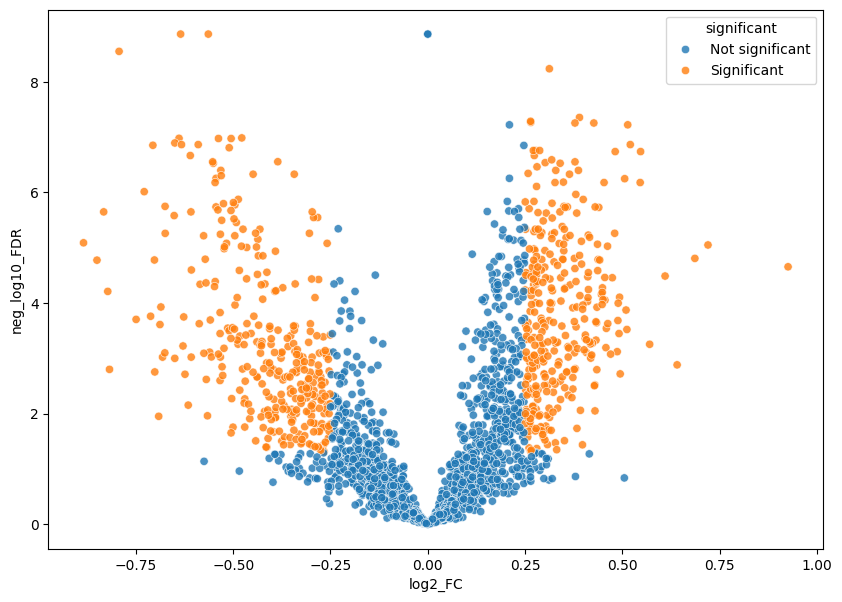

In [14]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='log2_FC', y='neg_log10_FDR', hue='significant', alpha=0.8)

In [15]:
#add labels to the Volcano plot
df_labeled = pd.read_csv("df_prot_inv.csv")
gene_names = df_labeled.iloc[2, :-1].values
protein_index_names = df_labeled.columns[:-1].astype(str)

# Create mapping
protein_map = pd.DataFrame({
    'Protein': protein_index_names,
    'Gene': gene_names,
})

In [16]:
results_df = pd.read_csv("DEA_transposed_clusters.csv")

In [17]:
# Ensure both sides are strings
results_df['Protein'] = results_df['Protein'].astype(str)
protein_map['Protein'] = protein_map['Protein'].astype(str)

# Now merge will work
results_annotated = results_df.merge(protein_map, on="Protein", how="left")

In [251]:
results_annotated.head()

,Protein,Cluster 1,Cluster 2,Mean Diff,p-value,FDR,Gene
0,0,0,1,-0.030642,0.558562,0.634495,HBB
1,1,0,1,0.007027,0.875282,0.906078,HBA1
2,2,0,1,0.244297,0.010965,0.023568,FASN
3,3,0,1,-0.118188,0.101448,0.150836,HIST1H4A
4,4,0,1,0.255032,0.000701,0.002400,ACTB


In [18]:
# Save updated result
results_annotated.to_csv("DEA_with_gene_names.csv", index=False)

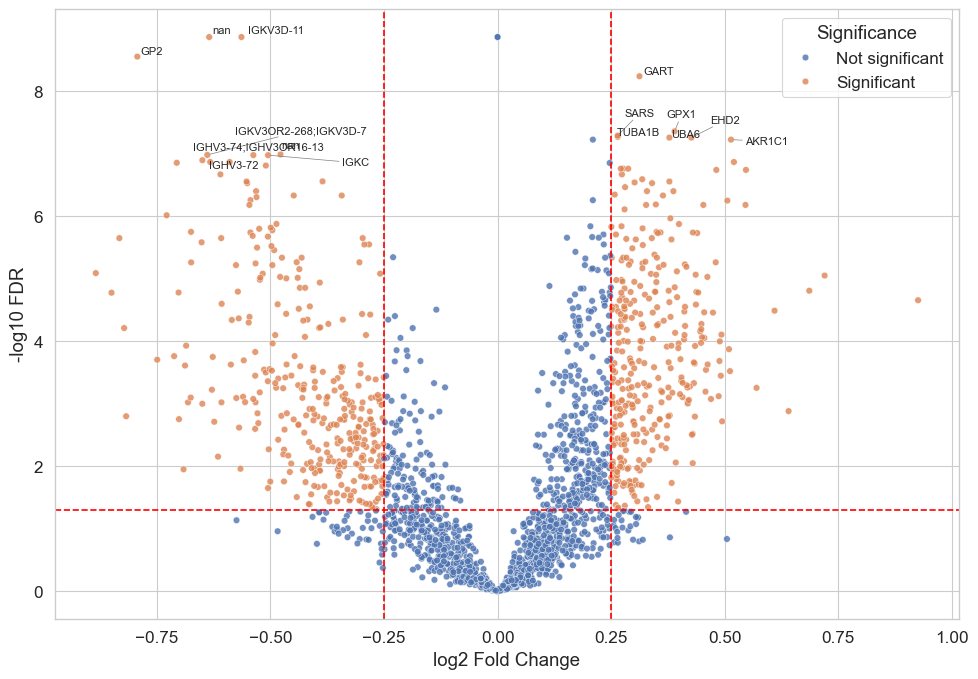

In [53]:
df_plot = results_annotated.copy()

df_plot['log2_FC'] = df_plot['Mean Diff']
df_plot['FDR'] = df_plot['FDR'].replace(0, 1e-300)
df_plot['neg_log10_FDR'] = -np.log10(df_plot['FDR'])

fc_thresh = 0.25
fdr_thresh = 0.05

df_plot['significant'] = 'Not significant'
df_plot.loc[(abs(df_plot['log2_FC']) >= fc_thresh) & (df_plot['FDR'] < fdr_thresh), 'significant'] = 'Significant'

#label top 20
top_genes = df_plot[df_plot['significant'] == 'Significant'].nsmallest(15, 'FDR')
#top_genes = df_plot[(df_plot['significant'] == 'Significant') & (df_plot['FDR'] < 0.000001)]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x='log2_FC', y='neg_log10_FDR', hue='significant', alpha=0.8)

texts = []
for _, row in top_genes.iterrows():
    label = row['Gene']
    texts.append(plt.text(row['log2_FC'], row['neg_log10_FDR'], label, fontsize=8))

# Auto-adjust to reduce overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

#for _, row in top_genes.iterrows():
#    plt.text(row['log2_FC'], row['neg_log10_FDR'], row['Gene'], fontsize=8,
#             ha='right' if row['log2_FC'] < 0 else 'left')

plt.axhline(-np.log10(fdr_thresh), color='red', linestyle='--')
plt.axvline(fc_thresh, color='red', linestyle='--')
plt.axvline(-fc_thresh, color='red', linestyle='--')

#plt.title("Volcano Plot: With Gene Labels")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 FDR")
plt.legend(title="Significance")
plt.tight_layout()
plt.show()

In [54]:
plt.draw()
plt.savefig("volcano_plot_smart_labels.png", dpi=300, bbox_inches='tight')
plt.close()

Differential Expression Analysis, retrive DEP names

In [19]:
print(results_annotated.columns.tolist())

['Protein', 'Cluster 1', 'Cluster 2', 'Mean Diff', 'p-value', 'FDR', 'Gene']


In [21]:
fdr_thresh = 0.05
fc_thresh = 0.25

# Recalculate significance if needed
results_annotated['Significant'] = (results_annotated['FDR'] < fdr_thresh) & (abs(results_df['Mean Diff']) >= fc_thresh)

#Count total DE
total_DE = results_annotated['Significant'].sum()

#Count upregulated (positive log2FC)
upregulated = results_annotated[(results_annotated['Significant']) & (results_annotated['Mean Diff'] > 0)].shape[0]

#Count downregulated
downregulated = results_annotated[(results_annotated['Significant']) & (results_annotated['Mean Diff'] < 0)].shape[0]

#Output
print(f"Total DE proteins: {total_DE}")
print(f"Upregulated: {upregulated}")
print(f"Downregulated: {downregulated}")

Total DE proteins: 665
Upregulated: 333
Downregulated: 332


In [22]:
#Save total upregulated hits for PPI
upregulated_genes = results_annotated[
    (results_annotated['Significant']) & 
    (results_annotated['Mean Diff'] > 0)
]['Gene'].dropna().drop_duplicates()

upregulated_genes.to_csv("upregulated_genes_STRING_FC05.txt", index=False, header=False)

print(f"Exported {len(upregulated_genes)} upregulated genes to STRING.")

Exported 329 upregulated genes to STRING.


In [23]:
#Save total downregulated hits for PPI
downregulated_genes = results_annotated[
    (results_annotated['Significant']) & 
    (results_annotated['Mean Diff'] < 0)
]['Gene'].dropna().drop_duplicates()

downregulated_genes.to_csv("downregulated_genes_STRING_FC05.txt", index=False, header=False)

print(f"Exported {len(downregulated_genes)} downregulated genes to STRING.")

Exported 304 downregulated genes to STRING.


In [24]:
#Extract top 20 DEP
# Filter significant DE genes
sig_df = results_annotated[results_annotated['Significant']]

# Top N up/downregulated
top_n = 329

top_up = sig_df.sort_values('Mean Diff', ascending=False).head(top_n)
top_down = sig_df.sort_values('Mean Diff', ascending=True).head(top_n)

# Save to CSV
top_up.to_csv("top_upregulated_proteins.csv", index=False)
top_down.to_csv("top_downregulated_proteins.csv", index=False)

# Display summary
print("Top Upregulated Proteins:")
print(top_up[['Gene', 'Mean Diff', 'FDR']])

print("\nTop Downregulated Proteins:")
print(top_down[['Gene', 'Mean Diff', 'FDR']])


Top Upregulated Proteins:
        Gene  Mean Diff       FDR
1782   PLIN5   0.925712  0.000022
1830    NAT1   0.719970  0.000009
823   KLHL31   0.686241  0.000016
1834    SDSL   0.640656  0.001318
1838    KLC4   0.609736  0.000033
...      ...        ...       ...
735     NONO   0.251880  0.003773
515     GARS   0.251753  0.000028
896      CSK   0.251541  0.000252
1518  GOLPH3   0.251309  0.002953
249     VARS   0.251295  0.000005

[329 rows x 3 columns]

Top Downregulated Proteins:
               Gene  Mean Diff       FDR
1873       IGLV5-45  -0.884491  0.000008
1323       IGHV3-49  -0.849923  0.000017
1980          SPRR3  -0.832674  0.000002
1879           MMP9  -0.822189  0.000062
982            FCN2  -0.817757  0.001591
...             ...        ...       ...
773           PARK7  -0.253602  0.010039
1369          CISD2  -0.253556  0.020915
75         LGALS3BP  -0.253308  0.001708
1570  RPL26;RPL26L1  -0.251324  0.004430
1045           BST1  -0.251085  0.015618

[329 rows x 3 column

In [313]:
# Load the files
top_up = pd.read_csv("top_upregulated_proteins.csv")
top_down = pd.read_csv("top_downregulated_proteins.csv")

# Save gene lists (1 per line, no headers)
top_up['Gene'].dropna().drop_duplicates().to_csv("string_upregulated_genes.txt", index=False, header=False)
top_down['Gene'].dropna().drop_duplicates().to_csv("string_downregulated_genes.txt", index=False, header=False)

PROTEIN-PROTEIN INTERACTION TSV ANALYSIS

DOWNREGULATED

In [59]:
#load TSV file got from STRING PPI
df_downregulated_PPI = pd.read_csv("string_interactions_FC05_down.tsv", sep="\t")
print(f"Total interactions: {len(df_downregulated_PPI)}")

Total interactions: 142


In [60]:
high_conf_df = df_downregulated_PPI[df_downregulated_PPI['combined_score'] >= 0.7]

In [61]:
num_high_conf = high_conf_df.shape[0]

In [62]:
unique_proteins = pd.unique(high_conf_df[['#node1', 'node2']].values.ravel())

In [63]:
unique_proteins_df = pd.DataFrame(unique_proteins, columns=["Protein"])

In [64]:
unique_proteins_df.to_csv("HC_downregulated_genes_05.txt", index=False, header=False)

In [ ]:
UPREGULATED

In [340]:
#load TSV file got from STRING PPI (upregulated and downregulated)
df_upregulated_PPI = pd.read_csv("upregulated_string_interactions.tsv", sep="\t")
print(f"Total interactions: {len(df_upregulated_PPI)}")

high_conf_df_up = df_upregulated_PPI[df_upregulated_PPI['combined_score'] >= 0.7]
num_high_conf_up = high_conf_df_up.shape[0]
unique_proteins_up = pd.unique(high_conf_df_up[['#node1', 'node2']].values.ravel())
unique_proteins_df_up = pd.DataFrame(unique_proteins_up, columns=["Protein"])
unique_proteins_df_up.to_csv("HC_upregulated_genes.txt", index=False, header=False)
unique_proteins_df_up.to_csv("HC_upregulated_genes.txt", index=False, header=False)

Total interactions: 2542
